In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random

from sklearn import linear_model, svm
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed

from ipynb.fs.full.get_data import getTFData, lagData, addSettings, cScale, pltS

# Remaining Useful Life Estimation

### NASA Turbofan Data - Exploration

Data Set: FD004\
Train trjectories: 248\
Test trajectories: 249\
Conditions: SIX\
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1)	unit number\
2)	time, in cycles\
3)	operational setting 1\
4)	operational setting 2\
5)	operational setting 3\
6)	sensor measurement  1\
7)	sensor measurement  2\
...\
26)	sensor measurement  26

Reference: A. Saxena, K. Goebel, D. Simon, and N. Eklund, “Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation”, in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.

In [96]:
train, test = getTFData(sets = [4])
train.head()

,id,dt,set1,set2,set3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,rul,rulfrac
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320,1.000000
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319,0.996875
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318,0.993750
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317,0.990625
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316,0.987500


In [63]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,61249.0,124.325181,71.995350,1.0000,60.000000,126.0000,185.000000,249.0000
dt,61249.0,134.311417,89.783389,1.0000,62.000000,123.0000,191.000000,543.0000
set1,61249.0,23.999823,14.780722,0.0000,10.004600,25.0014,41.998100,42.0080
set2,61249.0,0.571347,0.310703,0.0000,0.250700,0.7000,0.840000,0.8420
set3,61249.0,94.031576,14.251954,60.0000,100.000000,100.0000,100.000000,100.0000
s1,61249.0,472.882435,26.436832,445.0000,445.000000,462.5400,491.190000,518.6700
s2,61249.0,579.420056,37.342647,535.4800,549.330000,555.7400,607.070000,644.4200
s3,61249.0,1417.896600,106.167598,1242.6700,1350.550000,1367.6800,1497.420000,1613.0000
s4,61249.0,1201.915359,119.327591,1024.4200,1119.490000,1136.9200,1302.620000,1440.7700
s5,61249.0,8.031626,3.622872,3.9100,3.910000,7.0500,10.520000,14.6200


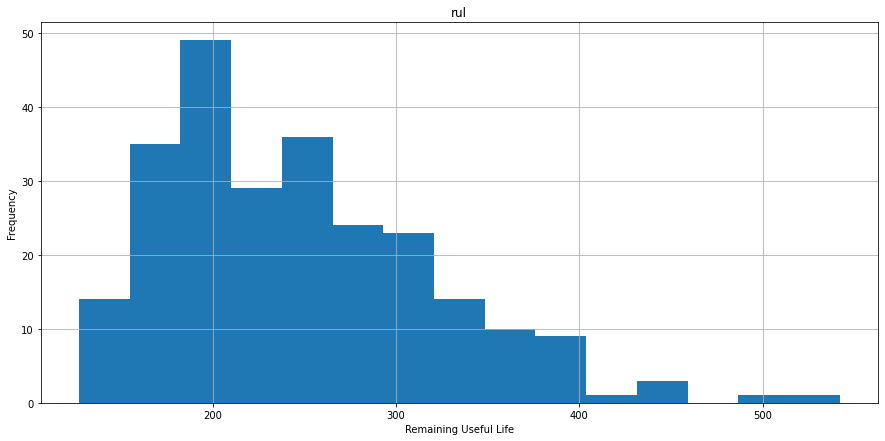

In [64]:
rul = train[['id', 'rul']].groupby('id').max()
rul.hist(bins=15, figsize=(15,7))
plt.xlabel('Remaining Useful Life')
plt.ylabel('Frequency')
plt.show()

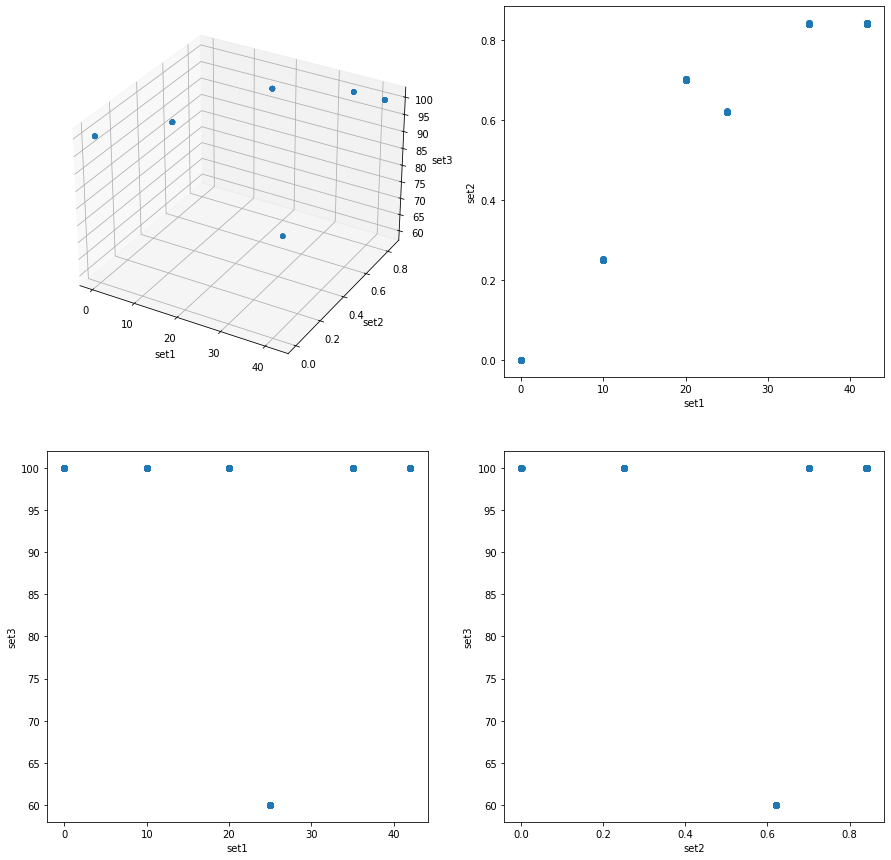

In [65]:
settings = train[['set1','set2','set3']].copy()
points = settings.values
points = points[random.sample(range(len(settings)), 100)]

%matplotlib inline

fig = plt.figure(figsize=(15,15))

f3D = fig.add_subplot(221, projection='3d')
f3D.scatter3D(points[:,0], points[:,1], points[:,2])
f3D.set_xlabel('set1')
f3D.set_ylabel('set2')
f3D.set_zlabel('set3')

f12 = fig.add_subplot(222)
f12.scatter(points[:,0], points[:,1])
f12.set_xlabel('set1')
f12.set_ylabel('set2')

f13 = fig.add_subplot(223)
f13.scatter(points[:,0], points[:,2])
f13.set_xlabel('set1')
f13.set_ylabel('set3')

f23 = fig.add_subplot(224)
f23.scatter(points[:,1], points[:,2])
f23.set_xlabel('set2')
f23.set_ylabel('set3')
plt.show()

In [97]:
train = addSettings(train)
test = addSettings(test)

In [93]:
test.head()

,id,dt,s2,s3,s4,s7,s8,s9,s11,s12,...,s20,s21,rul,rulfrac,c1,c2,c3,c4,c5,c6
0,1,1,-1.291986,-0.371035,-2.446822,-1.269701,-1.611846,-1.362232,-1.804439,-1.255108,...,-1.285619,-0.196676,251,1.000000,0,0,1,0,0,0
1,1,2,-1.343866,-0.773963,-2.045458,-1.254597,-0.958320,-1.064475,-2.395428,-1.322474,...,0.389345,-0.162154,250,0.996016,0,0,0,1,0,0
2,1,3,-0.533916,-1.884844,-2.063497,-1.533376,-0.314767,-1.197224,-1.797836,-0.883522,...,-1.962677,0.894890,249,0.992032,0,0,0,0,0,1
3,1,4,-0.620062,-1.950033,-1.910489,-1.639571,-0.482243,-1.433602,-1.068035,-1.406676,...,-0.529744,-1.907498,248,0.988048,0,0,0,0,0,1
4,1,5,-0.957179,-1.810317,-1.206594,-1.434303,-1.293037,-1.397256,-2.013464,-1.272462,...,-0.241114,0.034869,247,0.984064,0,0,0,0,1,0


In [95]:
def pltSC(data, s, c, mod = 10):
    plt.figure(figsize=(15,5))
    df = data.copy()
    df = df[df[c] == 1]
    counter = 0
    for i in df['id'].unique():
        counter += 1
        if counter % mod == 0:
            plt.plot('rul', s, data = df[df['id'] == i])
    plt.xlim(500, 0)
    plt.xticks(np.arange(0, 525, 25))
    plt.ylabel(s)
    plt.xlabel('Remaining Useful Life')
    plt.show()

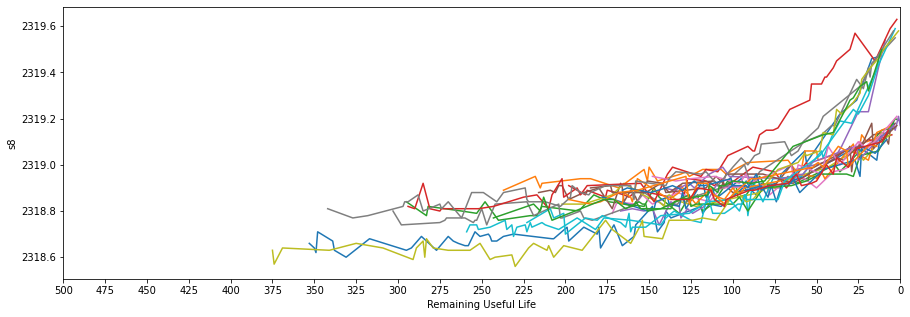

In [100]:
pltSC(train, 's8', 'c2')

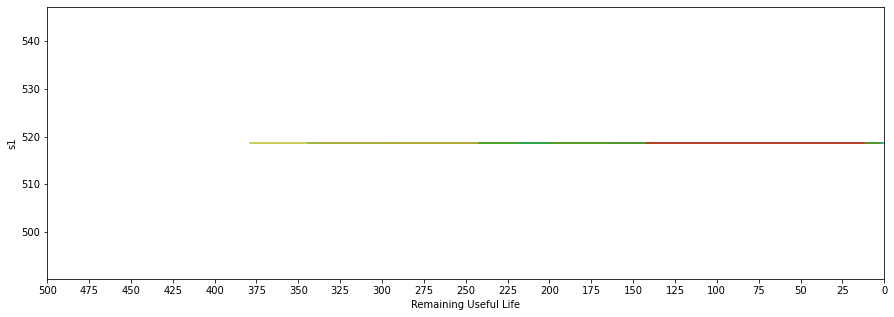

In [98]:
pltSC(train, 's1', 'c1')

In [101]:
train = train.drop(columns = ['set1', 'set2', 'set3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'])
test = test.drop(columns = ['set1', 'set2', 'set3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'])

sensors = train.columns
sensors = sensors.drop(['id', 'dt', 'rul', 'rulfrac', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6'])

In [102]:
train, test = cScale(train, test, sensors = sensors)

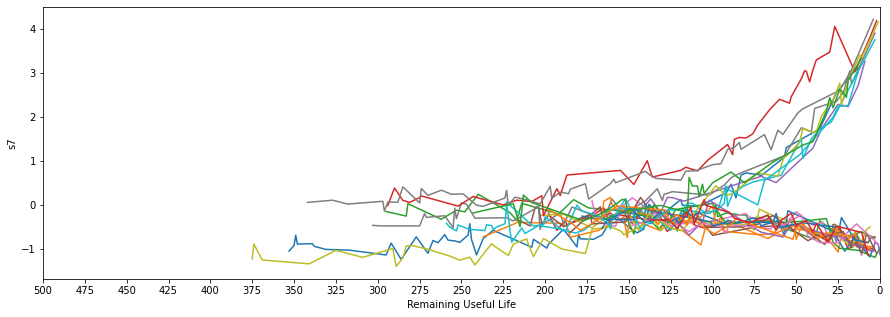

In [72]:
pltSC(train, 's7', 'c2')

### Regression

In [73]:
cols = sensors.to_list() + ['c1', 'c2' , 'c3', 'c4', 'c5', 'c6']

In [74]:
X_train = train.loc[:, cols].values
Y_train = train.loc[:, 'rul'].values

In [75]:
df = test.groupby('id').last().reset_index()
X_test = df.loc[:, cols].values
Y_test = df.loc[:, 'rul'].values

In [76]:
lm = linear_model.LinearRegression()
lm.fit(X_train, Y_train)

LinearRegression()

In [77]:
Y_hat = lm.predict(X_train)

In [78]:
print("Training:")
print("Sqrt MSE: %.2f" % np.sqrt(mean_squared_error(Y_train, Y_hat)))
print("R2: %.2f" % r2_score(Y_train, Y_hat))

Training:
Sqrt MSE: 61.17
R2: 0.54


In [79]:
Y_hat = lm.predict(X_test)

In [80]:
print("Testing:")
print("Sqrt MSE: %.2f" % np.sqrt(mean_squared_error(Y_test, Y_hat)))
print("R2: %.2f" % r2_score(Y_test, Y_hat))

Testing:
Sqrt MSE: 48.67
R2: 0.20


### Lagged Regression

In [81]:
maxlag = test[['id','rul']].groupby('id').size().min() - 1
print("Maximal Lag without NA is %d" %maxlag)

Maximal Lag without NA is 18


In [82]:
seql = 10

In [83]:
train_LR = train.copy()
test_LR = test.copy()

In [84]:
train_LR = lagData(train_LR, lagsize = seql, dropna = True)

In [103]:
train_LR.head()

,id,dt,s2,s2_lg_1,s2_lg_2,s2_lg_3,s2_lg_4,s2_lg_5,s2_lg_6,s2_lg_7,...,c6_lg_1,c6_lg_2,c6_lg_3,c6_lg_4,c6_lg_5,c6_lg_6,c6_lg_7,c6_lg_8,c6_lg_9,c6_lg_10
0,1,11,-0.878849,-1.006986,0.155251,-0.921572,-1.296178,-1.637138,-1.654832,-1.675349,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,1,12,-2.131654,-0.878849,-1.006986,0.155251,-0.921572,-1.296178,-1.637138,-1.654832,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1,13,-1.084727,-2.131654,-0.878849,-1.006986,0.155251,-0.921572,-1.296178,-1.637138,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
3,1,14,-0.013229,-1.084727,-2.131654,-0.878849,-1.006986,0.155251,-0.921572,-1.296178,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,1,15,-1.603005,-0.013229,-1.084727,-2.131654,-0.878849,-1.006986,0.155251,-0.921572,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [85]:
df = test_LR.groupby('id')
df = pd.concat([df.tail(seql + 1)])
test_LR = lagData(df, seql, dropna = True)

In [86]:
cols = train_LR.columns.drop(['id', 'dt', 'rul', 'rulfrac']).to_list()

In [87]:
X_train_LR = train_LR.loc[:, cols].values
Y_train_LR = train_LR.loc[:, 'rul'].values

X_test_LR = test_LR.loc[:, cols].values
Y_test_LR = test_LR.loc[:, 'rul'].values

In [88]:
lm_LR = linear_model.LinearRegression()
lm_LR.fit(X_train_LR, Y_train_LR)

LinearRegression()

In [89]:
Y_hat = lm_LR.predict(X_train_LR)

In [90]:
print("Training:")
print("Sqrt MSE: %.2f" % np.sqrt(mean_squared_error(Y_train_LR, Y_hat)))
print("R2: %.2f" % r2_score(Y_train_LR, Y_hat))

Training:
Sqrt MSE: 56.68
R2: 0.58


In [91]:
Y_hat = lm_LR.predict(X_test_LR)

In [92]:
print("Testing:")
print("Sqrt MSE: %.2f" % np.sqrt(mean_squared_error(Y_test_LR, Y_hat)))
print("R2: %.2f" % r2_score(Y_test_LR, Y_hat))

Testing:
Sqrt MSE: 42.84
R2: 0.38


### LSTM

In [32]:
X_train_temp = train.drop(columns = ['dt', 'rul', 'rulfrac']).copy()
Y_train_temp = train['rul'].copy()
groups_t = train['id'].copy()

In [35]:
groupsplit = GroupShuffleSplit(n_splits = 1, train_size = 0.8 , random_state = 42)

In [36]:
for itrain, ival in groupsplit.split(X_train_temp, Y_train_temp, groups = groups_t):
    X_train = X_train_temp.iloc[itrain].copy()
    Y_train = Y_train_temp.iloc[itrain].copy()
    X_val = X_train_temp.iloc[ival].copy()
    Y_val = Y_train_temp.iloc[ival].copy()    
groups_t = X_train['id'].copy()
groups_v = X_val['id'].copy()
X_train = X_train.drop(columns = ['id'])
X_val = X_val.drop(columns = ['id'])

In [37]:
seql = 10
n = X_train.shape[0]
X_traindata = []
Y_traindata = []
Xtrd = X_train.values
Ytrd = Y_train.values
for stt, nd in zip(range(0, n - seql + 1), range(seql, n + 1)):
    if len(groups_t[stt:nd].unique()) == 1:
        X_traindata.append(Xtrd[stt:nd, :])
        Y_traindata.append(Ytrd[nd - 1])
Xtraindata = np.asarray(X_traindata)
Ytraindata = np.asarray(Y_traindata)

In [38]:
n = X_val.shape[0]
X_valdata = []
Y_valdata = []
Xvld = X_val.values
Yvld = Y_val.values
for stt, nd in zip(range(0, n - seql + 1), range(seql, n + 1)):
    if len(groups_t[stt:nd].unique()) == 1:
        X_valdata.append(Xvld[stt:nd, :])
        Y_valdata.append(Yvld[nd - 1])        
Xvaldata = np.asarray(X_valdata)
Yvaldata = np.asarray(Y_valdata)

In [39]:
X_test = test.drop(columns = ['dt', 'rul', 'rulfrac']).copy()
Y_test = test['rul'].copy()

In [40]:
X_testdata = []
Y_testdata = []
for i, d in X_test.groupby('id'):
    first = d.index[0]
    last = d.index[-1] 
    if d.shape[0] < seql:
        pad = pd.DataFrame(-100, index = np.arange(seql), columns = X_test.columns)
        idx = pad.shape[0] - d.shape[0]
        pad.iloc[idx:,:] = d
        Xid = pad
    else:
        Xid = d.tail(seql)
    Xid = Xid.drop(columns = ['id'])
    X_testdata.append(Xid.values)
    Y_testdata.append(Y_test[last])
Xtestdata = np.asarray(X_testdata)
Ytestdata = np.asarray(Y_testdata)

In [43]:
simpleLSTM = Sequential()
simpleLSTM.add(Masking(mask_value=-100., input_shape=(seql, Xtraindata.shape[2])))
simpleLSTM.add(LSTM(32, activation='tanh'))
simpleLSTM.add(Dense(1))

In [58]:
simpleLSTM.compile(loss='mean_squared_error', optimizer='adam')
history = simpleLSTM.fit(Xtraindata, Ytraindata,
                    validation_data=(Xvaldata, Yvaldata),
                    epochs=5,
                   batch_size=32)

Epoch 1/5
1485/1485 [==============================] - 12s 6ms/step - loss: 2901.2798 - val_loss: 3913.0918
Epoch 2/5
1485/1485 [==============================] - 8s 5ms/step - loss: 2701.6733 - val_loss: 3677.9775
Epoch 3/5
1485/1485 [==============================] - 8s 6ms/step - loss: 2630.3123 - val_loss: 3719.9785
Epoch 4/5
1485/1485 [==============================] - 9s 6ms/step - loss: 2589.8340 - val_loss: 3740.6819
Epoch 5/5
1485/1485 [==============================] - 9s 6ms/step - loss: 2551.6157 - val_loss: 3822.3052


In [105]:
x = [1,2,3,4,5]

In [108]:
x.sort(reverse = True)

In [109]:
x

[5, 4, 3, 2, 1]

In [60]:
history.history

{'loss': [2901.27978515625,
  2701.67333984375,
  2630.312255859375,
  2589.833984375,
  2551.61572265625],
 'val_loss': [3913.091796875,
  3677.9775390625,
  3719.978515625,
  3740.681884765625,
  3822.30517578125]}

In [45]:
Ypredtrain = simpleLSTM.predict(Xtraindata)
print("Training:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytraindata, Ypredtrain)))
print("R2: %.2f" % r2_score(Ytraindata, Ypredtrain))

Training:
Sqrt mse: 55.86
R2: 0.60


In [46]:
Ypredtest = simpleLSTM.predict(Xtestdata)
print("Testing:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytestdata, Ypredtest)))
print("R2: %.2f" % r2_score(Ytestdata, Ypredtest))

Testing:
Sqrt mse: 33.81
R2: 0.62


In [104]:
simpleLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 10, 20)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                6784      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 6,817
Trainable params: 6,817
Non-trainable params: 0
_________________________________________________________________
